# Time series features extraction 

This interactive notebook shows Khiva´s time series feature extraction and uses it to train a simple prediction model simplifying the task by summarizing the time series by using features which describes those time series.

The example uses 100 time-series provided by commercial sites during 2012, which are tagged by subindustry.  The dataset has in excess of 10,000,000 points.  To reduce the dataset to a set manageable with this notebook computational resources, we use Khiva´s algorithms to produce an alternative version without loosing any of the properties.

This exercise is focused on: 
1. Extract the time series features. 
2. Predict the subindustry of some sites. 


In [ ]:
from khiva.features import *
import khiva as kv
import pandas as pd
import numpy as np
import time
import sklearn.utils
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from ipywidgets import IntSlider
from ipywidgets import interact
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 5]

## Backend
Prints the backend used. CPU, CUDA and OPENCL backends are available for Khiva.  
  
>This application executed in a macOS High Sierra with a 2,9 GHz Intel Core i7 processor takes 8,34 seconds in extracting the features using the same CPU backend.

In [28]:
print(kv.get_backend())

KHIVABackend.KHIVA_BACKEND_OPENCL


## Metadata load 
We are loading an anonymised 5-minute energy usage data for 100 commercial / industrial sites for 2012. 
The sites metadata contains the site ID, the industry, square footage, lat/lng and timezone. 

In [29]:
all_sites = pd.read_csv("/home/khiva-binder/features/energy-data/meta/all_sites.csv")
file_names = []
# This is needed to check the accuracy of the predictive modelling step.
for name in all_sites["SITE_ID"].values:
    file_names.append(name)

## Data load
The original dataset contains 100 time-series, which was a total of 10,531,288 data points. This original dataset was re-dimensioned using Khiva´s implementation of [Visvalingam](http://khiva-python.readthedocs.io/en/latest/khiva.html#khiva.dimensionality.visvalingam) algorithm.

The result is a dataset of 100 time-series which is a total of 1,666,600 data points. After the re-dimension, the dataset was stored in a binary and then loaded into a Khiva Array. 

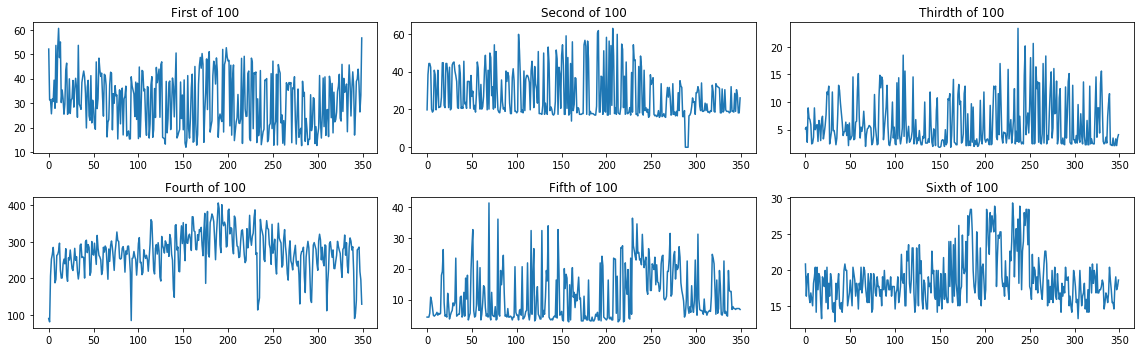

In [30]:
arr_tmp  = kv.Array(np.load("/home/khiva-binder/features/time_series_redimensioned.npy"))
time_series= arr_tmp.to_numpy()
f, axarr = plt.subplots(2, 3)

axarr[0, 0].plot(range(len(time_series[0])), time_series[0])
axarr[0, 0].set_title('First of 100')
axarr[0, 1].plot(range(len(time_series[1])), time_series[1])
axarr[0, 1].set_title('Second of 100')
axarr[0, 2].plot(range(len(time_series[4])), time_series[4])
axarr[0, 2].set_title('Thirdth of 100')
axarr[1, 0].plot(range(len(time_series[2])), time_series[2])
axarr[1, 0].set_title('Fourth of 100')
axarr[1, 1].plot(range(len(time_series[3])), time_series[3])
axarr[1, 1].set_title('Fifth of 100')
axarr[1, 2].plot(range(len(time_series[5])), time_series[5])
axarr[1, 2].set_title('Sixth of 100')
plt.tight_layout()
plt.show()

## Features extraction 
We use Khiva to extract 28 features from the time-series, so we can generate a features matrix for applying a predictive modelling.

For a full description of all feature extraction operations available in Khiva, do please have a look to the [documentation](http://khiva-python.readthedocs.io/en/latest/khiva.html#module-khiva.features).

In [32]:
start = time.time()

features = np.stack([abs_energy(arr_tmp).to_numpy(),
#                     absolute_sum_of_changes(arr_tmp).to_numpy(),
#                     count_above_mean(arr_tmp).to_numpy(),
#                     count_below_mean(arr_tmp).to_numpy(),
#                     first_location_of_maximum(arr_tmp).to_numpy(),
#                     first_location_of_minimum(arr_tmp).to_numpy(),
#                     has_duplicates(arr_tmp).to_numpy(),
#                     has_duplicate_max(arr_tmp).to_numpy(),
#                     kurtosis(arr_tmp).to_numpy(),
#                     last_location_of_maximum(arr_tmp).to_numpy(),
#                     last_location_of_minimum(arr_tmp).to_numpy(),
#                     has_duplicate_min(arr_tmp).to_numpy(),
#                     longest_strike_above_mean(arr_tmp).to_numpy(),
#                     longest_strike_below_mean(arr_tmp).to_numpy(),
#                     maximum(arr_tmp).to_numpy(),
#                     mean_absolute_change(arr_tmp).to_numpy(),
#                     minimum(arr_tmp).to_numpy(),
#                     number_crossing_m(arr_tmp, 0).to_numpy(),
#                     mean(arr_tmp).to_numpy(),
#                     median(arr_tmp).to_numpy(),
#                     mean_change(arr_tmp).to_numpy(),
#                     ratio_value_number_to_time_series_length(arr_tmp).to_numpy(),
#                     skewness(arr_tmp).to_numpy(),
#                     standard_deviation(arr_tmp).to_numpy(),
#                     sum_of_reoccurring_values(arr_tmp).to_numpy(),
#                     sum_values(arr_tmp).to_numpy(),
#                     variance(arr_tmp).to_numpy(),
#                     variance_larger_than_standard_deviation(arr_tmp).to_numpy()
                    ])

print("Time to extract the features : " + str(time.time() - start) + " seconds.")

features = features.transpose()


Time to extract the features : 0.0015192031860351562 seconds.


### Showing the features
Just a way to show the calculated features is to build a pandas dataframe and just display the five first entries.  

In [33]:
pandasDF = pd.DataFrame(columns=['abs_energy',
#                                  'absolute_sum_changes','count_above_mean','count_below_mean',
#     'first_location_of_maximum','first_location_of_minimum','has_duplicates',
#     'has_duplicate_max','kurtosis','last_location_of_maximum','last_location_of_minimum',
#     'has_duplicate_min','longest_strike_above_mean','longest_strike_below_mean',
#     'maximum','mean_absolute_change','minimum','number_crossing_m',
#     'mean','median','mean_change','ratio_value_number_to_time_series_length',
#     'skewness','standard_deviation','sum_of_reoccurring_values','sum_values',
#     'variance','variance_larger_than_standard_deviation'
                                ], data = features[0:,0:])
pandasDF.head(5)

ValueError: Shape of passed values is (100, 1), indices imply (100, 28)

## Features matrix and target definition.
Here, the features matrix and target matrix are defined in the following way: 
1. **Features matrix** Composed by the features extracted. 
2. **Target matrix** Composed by the subindustries’ tag of each time series. 

In [13]:
y = all_sites["SUB_INDUSTRY"].values
X = features

## Features matrix pre-process 
A simple pre-process is executed to scale the features matrix. 

In [14]:
X = scale(X)

## Shuffle 
Several shuffles are done to distribute the samples

In [15]:
for i in range(15):
    X, y, file_names = sklearn.utils.shuffle(X, y, file_names, random_state=0)

## Predictive modelling 
In this step, we create a model, fit it and predict a subset of samples. 

The reason to choose SVC as classifier are the following: 
* More than 50 samples for the training and less than 100k in total. 
* The intention to predict a category.  
* All data is labelled. 

The parameters chosen are based on a grid search based on a cross-validation(CV) step, focused on the accuracy of the model and using a K-FOLD(K=10) CV method. 


In [26]:
files_test = []
list_test_indices = []
test_files = [92, 45, 761, 10, 766, 400, 673, 49, 144, 496, 731, 281, 213, 197, 399]

for i in range(len(file_names)):
    # choosing always the same examples for testing to ensure the same results ....
    if file_names[i] in test_files:
        list_test_indices.append(i)
        files_test.append(file_names[i])

X_train = np.delete(X, list_test_indices, 0)
X_test = np.take(X, list_test_indices, 0)
y_train = np.delete(y, list_test_indices)
y_test = np.take(y, list_test_indices)


# Search for the best model optimising by accuracy
clf = svm.SVC()
k_range_parameter = {'degree':[3,4],'shrinking':[True,False],'probability':[True,False]}
mygridsearch = GridSearchCV(clf, k_range_parameter, cv = 10, scoring = 'accuracy' )
mygridsearch.fit(X_train, y_train)

# Get the best one...
bestclassifier = mygridsearch.best_estimator_

# Run some predictions over the test subset
y_pred = bestclassifier.predict(X_test)

# Get some stats out...
print("NUMBER OF ERRORS: " + str(sum(y_pred != y_test)))
print("ERROR RATE: " + str(1 - sum(y_pred == y_test) / float(len(y_pred))) + "%")
print("ACCURACY: " + str(sum(y_pred == y_test) / float(len(y_pred))) + "%")
print("PARAMETERS USED: "+ str(mygridsearch.best_params_))

NUMBER OF ERRORS: 8
ERROR RATE: 0.5333333333333333%
ACCURACY: 0.4666666666666667%
PARAMETERS USED: {'degree': 3, 'probability': True, 'shrinking': True}


In [17]:
def run_prediction(ts_index):
    global y_test
    global y_pred
    global time_series
    global test_files
   
    print("Expected : " + y_test[ts_index])
    print("Predicted: " + y_pred[ts_index])
   
    plt.plot(range(len(time_series[list_test_indices[ts_index]])), time_series[list_test_indices[ts_index]])
    plt.title("establishment: " + str(test_files[ts_index]))
    plt.show()
   
interact(run_prediction,ts_index=IntSlider(min=0, max=len(y_test)-1, step=1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='ts_index', max=14), Output()), …